<a href="https://colab.research.google.com/github/PTettey/Hello-World/blob/master/Automotive_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.7MB/s 
     |████████████████████████████████| 1.2MB 23.5MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 194kB 38.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 12.8MB 197kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


## A Look at the Data

#### Patient survey (HCAHPS) - Hospital




## Recommend with Collaborative Filtering

Evalute performance of collaborative filtering, with just first 100K rows for faster process:

In [2]:
#hide
from fastbook import *

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
#path = untar_data(URLs.ML_100k)
path = Path('/content/gdrive/MyDrive/fastai-v3/data/Automotive')

In [4]:
#I use this command to check if the file is in that location. It lists the number of files contain in that folder
path.ls()

(#1) [Path('/content/gdrive/MyDrive/fastai-v3/data/Automotive/Automotive.csv')]

In [47]:
#I call the csv file and select the columns i want to use. I use the "usecols" command to specify which columns to choose
data = pd.read_csv("/content/gdrive/MyDrive/fastai-v3/data/Automotive/Automotive.csv", header=None,
                      names=['Item','User','Rating','Timestamp'])
data.head(10)

,Item,User,Rating,Timestamp
0,0209688726,A3ELV1VUCZZGL4,4.0,1439337600
1,0209688726,A2FD3FZ2WV6KHQ,2.0,1439337600
2,0209688726,A39NRKABAVSVSE,2.0,1439251200
3,0209688726,AQSBL5KODHSGW,5.0,1438128000
4,0209688726,AU45OQPK2J5JF,5.0,1436572800
5,0209688726,A5TACMBV2GTBS,5.0,1433980800
6,0209688726,A8WEXFRWX1ZHH,4.0,1430438400
7,0209688726,A262RPUOSCPP51,5.0,1524182400
8,0209688726,ABRUILETFGA81,5.0,1524096000
9,0209688726,ABCA1A8E4DGV1,1.0,1524096000


In [48]:
len(data)

7990166

In [49]:
Sample_data = data.sample(n = 1000000)

In [38]:
len(Sample_data)

1000000

In [50]:
Sample_data.head()

,Item,User,Rating,Timestamp
1652623,B001U60T9U,A2QDLK9VGCPC4H,4.0,1519516800
5273349,B000NRZGUO,A2PB09P51ENOD1,5.0,1454457600
745062,B000GOF4YC,AJKI9XPP0AYYW,5.0,1357430400
6457498,B00BFDIQC0,A1YWK0W0KB4T16,5.0,1490313600
3462006,B00IJEA7IY,A1BY40MHOYZNPJ,5.0,1467158400


## Creating the Dataloaders

We can then build a `DataLoaders` object from this table. By default, it takes the first column for the __Facility Name__, the second column for the __Patient Survey Star rating__, and the third column for the __Survey Respose Rate Percent__. 

In [53]:
dls = CollabDataLoaders.from_df(Sample_data, bs = 64, valid_pct=0.2)
dls.show_batch()

,Item,User,Rating
0,B00AO04VII,A1FG3GROKLJCQX,3.0
1,B00P9VKJR4,A274Y906KHYV8F,4.0
2,B00ZCLFE9Y,A8CBRDUU1I5Q5,5.0
3,B01FSKRPKO,A2AS8CFJ51GGEE,5.0
4,B000QUZ6TO,A2FQU2MZBR2JWV,1.0
5,B000VAPVBM,A2GJXHGBCMWBU5,5.0
6,B0096725JC,A2XQ2KO87W5E0U,5.0
7,B001CBMXNI,A10EPSFSI1Y09J,5.0
8,B00LDYGYIY,A3S45RL8SIR3TA,1.0
9,B00VNPOIGI,A2B2GNJGN2K0KL,5.0


In [54]:
y_range = [0.5,5.5]

In [55]:
learn = collab_learner(dls, n_factors=50, y_range=y_range, wd=1e-1)

ModuleAttributeError: ignored

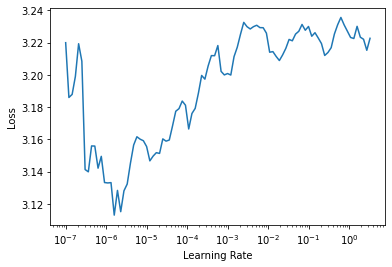

In [56]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [57]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,2.924787,2.918516,10:00
1,2.913870,2.912017,10:07
2,2.877709,2.907513,10:07


In [58]:
learn.save('Automotive-ratings')

Path('models/Automotive-ratings.pth')

In [59]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(305875, 50)
  (i_weight): Embedding(805924, 50)
  (u_bias): Embedding(305875, 1)
  (i_bias): Embedding(805924, 1)
)

## Intepreting Bias

The Embeddings should contain some interesting feature which we can extract to have a better insight.

We will extract the biases as well as their mean ratings in order to get informations about Automotives that are generally rated low or high no matter what user is rating them.

In [60]:
g = dls.groupby('Item')['Rating'].count()
top_automotive = g.sort_values(ascending=False).index.values[:1000]
top_automotive[:10]

AttributeError: ignored

So the top thousand are the automotive that have been rated the most, and so there hopefully automotive that we might have seen.That's the only reason I'm doing this. So I've called this `top_automotive` by which I mean not good automotive, just automotive we likely to have seen.

Not surprisingly, Star Wars is the one, at that point, the most people had put a rating to. Independence Day, there you go. We can then take our learner that we trained and asked it for the bias of the items listed here.